# Dataset dapat di download di www.marketwatch.com

In [1]:
# Import Seluruh Library
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Load & Preprocess Data
df = pd.read_csv('ADRO.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.sort_values('Date')
for col in ['Open', 'High', 'Low', 'Close']:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)
data = df[['Open', 'High', 'Low', 'Close']].values
data

array([[2440., 2540., 2430., 2530.],
       [2530., 2580., 2450., 2460.],
       [2470., 2480., 2380., 2380.],
       [2380., 2480., 2320., 2470.],
       [2470., 2520., 2400., 2400.],
       [2420., 2430., 2340., 2340.],
       [2360., 2390., 2320., 2320.],
       [2330., 2390., 2300., 2350.],
       [2380., 2420., 2360., 2360.],
       [2380., 2430., 2360., 2400.],
       [2420., 2470., 2400., 2410.],
       [2420., 2430., 2360., 2400.],
       [2400., 2420., 2350., 2350.],
       [2360., 2370., 2310., 2310.],
       [2330., 2350., 2320., 2320.],
       [2330., 2390., 2310., 2340.],
       [2340., 2360., 2280., 2300.],
       [2310., 2320., 2250., 2300.],
       [2310., 2340., 2290., 2330.],
       [2320., 2330., 2260., 2310.],
       [2310., 2370., 2290., 2330.],
       [2390., 2390., 2320., 2360.],
       [2360., 2370., 2260., 2290.],
       [2290., 2290., 2230., 2270.],
       [2270., 2270., 2200., 2210.],
       [2210., 2220., 2120., 2150.],
       [2150., 2260., 2140., 2240.],
 

In [4]:
# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [5]:
# Sequence Generator (target hanya Open)
def create_sequences(data, seq_length=3):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][0])  # Open saja
    return np.array(X), np.array(y)

seq_length = 3
X, y = create_sequences(scaled_data, seq_length)
n = len(X)
train_size = int(0.7 * n)
val_size = int(0.15 * n)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]


In [6]:
# Dataset
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = StockDataset(X_train, y_train)
val_ds = StockDataset(X_val, y_val)
test_ds = StockDataset(X_test, y_test)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=False)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=8, shuffle=False)

# Cara Kerja Transformer untuk Prediksi Saham
* Transformer adalah arsitektur deep learning yang menggunakan mekanisme self-attention untuk memproses data deret waktu (time series), seperti data harga saham.

* Tidak seperti LSTM yang memproses data secara sekuensial (satu per satu), Transformer memperhatikan seluruh urutan data input sekaligus. Dengan self-attention, model dapat “memperhatikan” hubungan antara setiap titik waktu dalam sequence, baik yang dekat maupun yang jauh.

* Pada prediksi saham, input berupa urutan data historis (misal: Open, High, Low, Close selama beberapa hari terakhir). Data ini diubah menjadi vektor fitur, lalu diproses oleh layer Transformer.

* Self-attention memungkinkan model mengenali pola penting, misalnya pengaruh data hari ke-1 terhadap hari ke-4, tanpa harus mengingat urutan secara eksplisit.

* Output dari Transformer (biasanya dari langkah waktu terakhir) kemudian diproses oleh layer output untuk menghasilkan prediksi harga saham pada hari berikutnya.

Intinya:
Transformer bekerja dengan mempelajari hubungan antar waktu dalam data historis saham melalui self-attention, sehingga mampu menangkap pola kompleks dan non-linear untuk prediksi harga saham, baik jangka pendek maupun panjang.

# Bagian 1: Arsitektur Model StockTransformer
Penjelasan:
1. input_dim=4: Jumlah fitur input per timestep (Open, High, Low, Close).

2. seq_length=3: Panjang window urutan (misal, 3 hari terakhir).

3. d_model=32: Ukuran vektor fitur internal pada Transformer (dimensi model).

4. nhead=2: Jumlah "kepala" (head) pada multi-head self-attention. Setiap head belajar pola berbeda pada data.

5. num_layers=2: Jumlah layer encoder pada Transformer.

Layer-layer:
1. self.input_fc: Layer linear untuk mengubah input dari 4 fitur menjadi d_model (32 fitur). Ini diperlukan karena Transformer biasanya bekerja pada vektor berdimensi lebih besar.

2. self.transformer: Stack dari beberapa TransformerEncoderLayer. Setiap layer belajar pola sekuensial (urutan waktu) dari data.

3. self.fc: Layer linear terakhir yang mengubah output Transformer menjadi 1 nilai (prediksi harga Open saja).

# Bagian 2: Forward Pass
Penjelasan:
1. x = self.input_fc(x): Ubah dimensi input dari (batch, seq_len, 4) menjadi (batch, seq_len, d_model).

2. x = x.permute(1, 0, 2): Ubah urutan dimensi menjadi (seq_len, batch, d_model) karena PyTorch Transformer mengharapkan input dengan urutan ini.

3. x = self.transformer(x): Proses seluruh sequence dengan Transformer Encoder.

4. x = x[-1]: Ambil output dari timestep terakhir (biasanya yang paling relevan untuk prediksi ke depan).

5. self.fc(x).squeeze(-1): Ubah dari (batch, 1) ke (batch,) agar hasilnya satu nilai per sample.

# Bagian 3: Training Loop
Penjelasan:
1. device: Memilih GPU jika tersedia, jika tidak maka CPU.

2. model = StockTransformer().to(device): Membuat instance model dan memindahkannya ke device.

3. criterion = nn.MSELoss(): Fungsi loss Mean Squared Error, cocok untuk regresi.

4. optimizer = torch.optim.Adam(...): Optimizer Adam, populer untuk deep learning.

In [7]:
# Transformer Model (output 1 neuron)
class StockTransformer(nn.Module):
    # Bagian 1
    def __init__(self, input_dim=4, seq_length=3, d_model=32, nhead=2, num_layers=2):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)
    # Bagian 2
    def forward(self, x):
        x = self.input_fc(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch, d_model)
        x = self.transformer(x)
        x = x[-1]  # Use last output
        return self.fc(x).squeeze(-1)

# Bagian 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StockTransformer().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


# Bagian 4
Training per Epoch:
1. model.train(): Set model ke mode training.

2. running_loss: Menyimpan total loss pada epoch ini.

3. for xb, yb in train_dl: Loop batch training.

* xb, yb = xb.to(device), yb.to(device): Pindahkan batch ke device.

* pred = model(xb): Dapatkan prediksi model.

* loss = criterion(pred, yb): Hitung loss antara prediksi dan target.

* optimizer.zero_grad(): Reset gradien.

* loss.backward(): Backpropagation.

* optimizer.step(): Update parameter.

* running_loss += loss.item(): Tambahkan loss batch ke total epoch.

Validation per Epoch:
1. model.eval(): Set model ke mode evaluasi (tanpa dropout, batchnorm, dll).

2. with torch.no_grad(): Tidak menghitung/mengupdate gradien (lebih hemat memori).

3. val_loss: Menyimpan total loss pada validation set.

4. Loop batch validation: Sama seperti training, tapi tanpa backward/step.

5. avg_train_loss/avg_val_loss: Rata-rata loss per epoch.

6. train_losses/val_losses: Disimpan untuk plotting learning curve.

# Kesimpulan
1. Model ini adalah implementasi Transformer Encoder untuk regresi time series.

2. Input: urutan data (misal, 3 hari × 4 fitur).

3. Output: prediksi 1 nilai (Open) untuk hari berikutnya.

4. Training loop menghitung dan mencetak train/validation loss setiap epoch, serta menyimpan loss untuk visualisasi learning curve.

In [8]:
# Bagian 4: Training with Validation
train_losses = []
val_losses = []
for epoch in range(50):
    model.train()
    running_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()
    avg_train_loss = running_loss / len(train_dl)
    avg_val_loss = val_loss / len(val_dl)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/50, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/50, Train Loss: 0.5371, Val Loss: 0.2522
Epoch 2/50, Train Loss: 0.4483, Val Loss: 0.3017
Epoch 3/50, Train Loss: 0.1143, Val Loss: 0.1418
Epoch 4/50, Train Loss: 0.0485, Val Loss: 0.0264
Epoch 5/50, Train Loss: 0.0785, Val Loss: 0.0298
Epoch 6/50, Train Loss: 0.0733, Val Loss: 0.0355
Epoch 7/50, Train Loss: 0.0238, Val Loss: 0.0013
Epoch 8/50, Train Loss: 0.0154, Val Loss: 0.0174
Epoch 9/50, Train Loss: 0.0170, Val Loss: 0.0021
Epoch 10/50, Train Loss: 0.0298, Val Loss: 0.0035
Epoch 11/50, Train Loss: 0.0099, Val Loss: 0.0094
Epoch 12/50, Train Loss: 0.0119, Val Loss: 0.0087
Epoch 13/50, Train Loss: 0.0087, Val Loss: 0.0046
Epoch 14/50, Train Loss: 0.0097, Val Loss: 0.0022
Epoch 15/50, Train Loss: 0.0067, Val Loss: 0.0083
Epoch 16/50, Train Loss: 0.0088, Val Loss: 0.0027
Epoch 17/50, Train Loss: 0.0078, Val Loss: 0.0040
Epoch 18/50, Train Loss: 0.0166, Val Loss: 0.0011
Epoch 19/50, Train Loss: 0.0117, Val Loss: 0.0154
Epoch 20/50, Train Loss: 0.0092, Val Loss: 0.0010
Epoch 21/

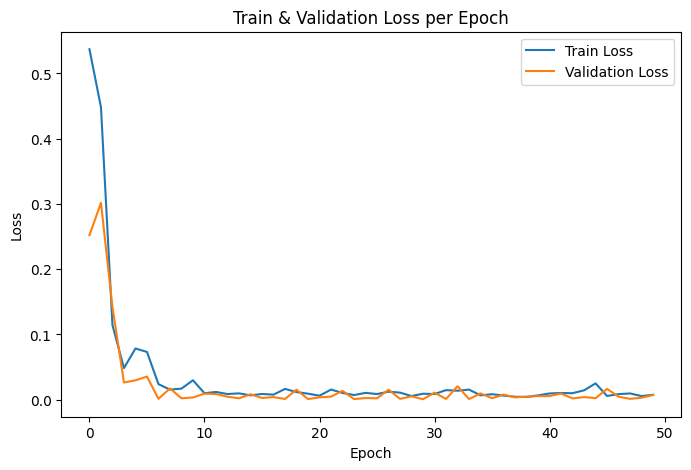

In [9]:
# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Validation Loss per Epoch')
plt.legend()
plt.show()

In [10]:
# Prediction
model.eval()
with torch.no_grad():
    X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_val_torch = torch.tensor(X_val, dtype=torch.float32).to(device)
    X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_pred = model(X_train_torch).cpu().numpy()
    y_val_pred = model(X_val_torch).cpu().numpy()
    y_test_pred = model(X_test_torch).cpu().numpy()

def inverse_transform_open(pred, scaler):
    dummy = np.zeros((len(pred), 4))
    dummy[:, 0] = pred
    inv = scaler.inverse_transform(dummy)
    return inv[:, 0]

y_train_inv = inverse_transform_open(y_train, scaler)
y_train_pred_inv = inverse_transform_open(y_train_pred, scaler)
y_val_inv = inverse_transform_open(y_val, scaler)
y_val_pred_inv = inverse_transform_open(y_val_pred, scaler)
y_test_inv = inverse_transform_open(y_test, scaler)
y_test_pred_inv = inverse_transform_open(y_test_pred, scaler)

In [11]:
# Error Metrics
def print_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

print_metrics(y_train_inv, y_train_pred_inv, "Transformer Train")
print_metrics(y_val_inv, y_val_pred_inv, "Transformer Validation")
print_metrics(y_test_inv, y_test_pred_inv, "Transformer Test")

Transformer Train - MAE: 37.52, RMSE: 47.66
Transformer Validation - MAE: 69.60, RMSE: 73.22
Transformer Test - MAE: 80.67, RMSE: 89.69


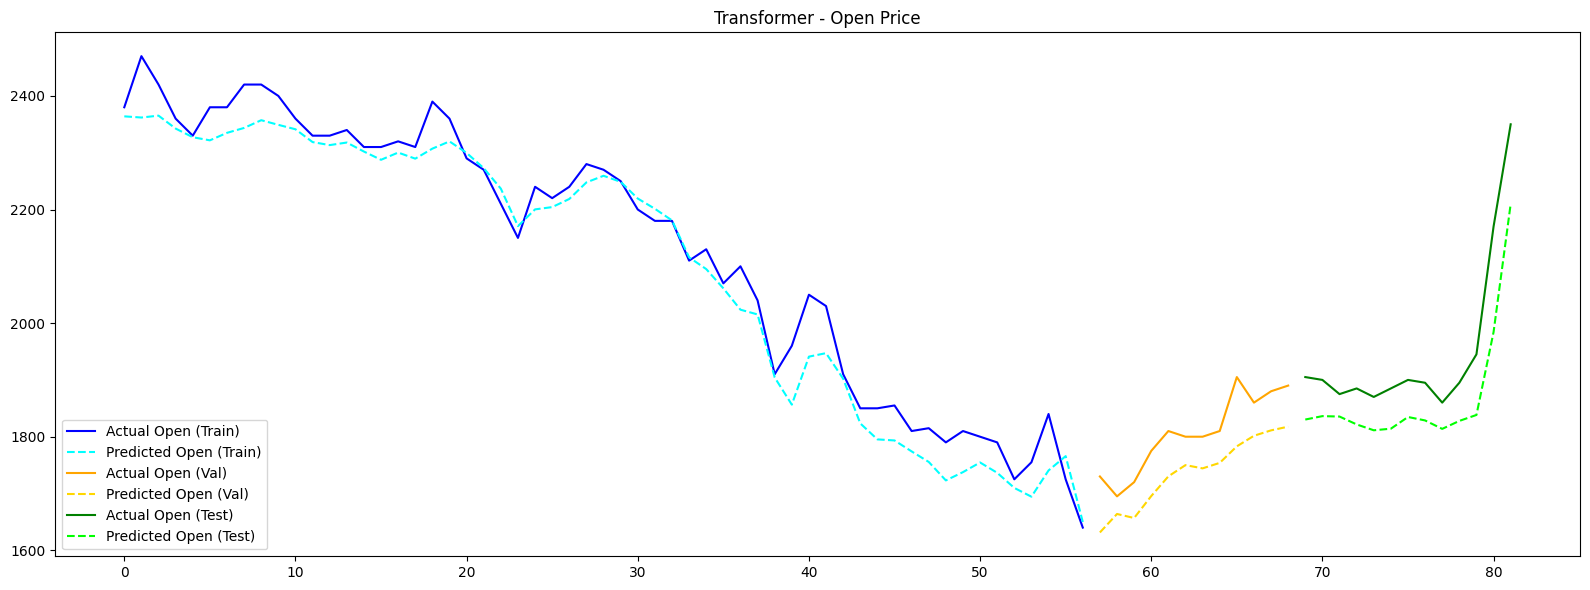

In [12]:
# Plot hasil prediksi Open
plt.figure(figsize=(16,6))
plt.plot(np.arange(len(y_train_inv)), y_train_inv, label='Actual Open (Train)', color='blue')
plt.plot(np.arange(len(y_train_pred_inv)), y_train_pred_inv, label='Predicted Open (Train)', color='cyan', linestyle='dashed')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(y_val_inv)), y_val_inv, label='Actual Open (Val)', color='orange')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(y_val_pred_inv)), y_val_pred_inv, label='Predicted Open (Val)', color='gold', linestyle='dashed')
plt.plot(np.arange(len(y_train_inv)+len(y_val_inv), len(y_train_inv)+len(y_val_inv)+len(y_test_inv)), y_test_inv, label='Actual Open (Test)', color='green')
plt.plot(np.arange(len(y_train_inv)+len(y_val_inv), len(y_train_inv)+len(y_val_inv)+len(y_test_pred_inv)), y_test_pred_inv, label='Predicted Open (Test)', color='lime', linestyle='dashed')
plt.legend()
plt.title('Transformer - Open Price')
plt.tight_layout()
plt.show()




In [14]:
# Prediksi Hari Esok & 3 Hari ke Depan (Multi-step)
def forecast_next_days(model, scaled_data, scaler, seq_length=3, steps=3):
    seq = scaled_data[-seq_length:].copy()
    preds = []
    model.eval()
    for _ in range(steps):
        inp = torch.tensor(seq.reshape(1, seq_length, 4), dtype=torch.float32).to(device)
        with torch.no_grad():
            pred = model(inp).cpu().numpy()[0]
        dummy = np.zeros((1, 4))
        dummy[0,0] = pred
        inv = scaler.inverse_transform(dummy)
        preds.append(inv[0,0])
        # Update sequence
        new_row = np.zeros(4)
        new_row[0] = pred
        seq = np.vstack([seq[1:], new_row])
    return preds

future_preds = forecast_next_days(model, scaled_data, scaler, seq_length=3, steps=3)
for i, open_p in enumerate(future_preds, 1):
    print(f"Transformer Prediksi Open Hari ke-{i}: {open_p:.2f}")

Transformer Prediksi Open Hari ke-1: 2252.27
Transformer Prediksi Open Hari ke-2: 1751.38
Transformer Prediksi Open Hari ke-3: 1669.41
